In [ ]:
# TODO:
# implement iterative policy evaluation of states
# Input: 
#   [<action>, .., ]
#   {<action>: <probability>}
#   gamma
#   {r(s'): <reward>}
#   map of world: ['SFFF', 
#                  'FHFH', 
#                  'FFFH', 
#                  'HFFG']
#   initial state: [row, col]

# Requirements:
#  + policy should be valid, i.e after fell into hole, no further actions are possibble 
#  + on return i get a map of states, e.g: 
# [[0.3, -0.04, 0.23, 0],
#  [0.3, -0.04, 0.23, 0]
#  [0.3, -0.04, 0.23, 0]
#  [0.3, -0.04, 0.23, 0]
#  [0.3, -0.04, 0.23, 0]] 
# 
# I should visualize the map (heat map)

In [1]:
import numpy as np

import seaborn

from functools import reduce

import copy
import matplotlib.pyplot as plt


In [ ]:
# environment:
# ['SFFF', 
#  'FHFH', 
#  'FFFH', 
#  'HFFG']

In [2]:
# initial state
s0 = (0, 0)
# probabilities to move by action
ps = {
      "left": 0.25, 
      "down": 0.25, 
      "right": 0.25, 
      "up": 0.25
    } 
# rewards to get when getting to a state
rs = {
      "H": 0,
      "F": 0,
      "S": 0,
      "G": 1
    }


world_map = ['SFFF', 
            'FHFH', 
            'FFFH', 
            'HFFG']

world_map = np.array([[env_name for env_name in line] for line in world_map])

gamma = 0.75

actions = [ "left", "down", "right","up"]
p = 1/len(actions)

## (2.a) Policy iteration

In [5]:
n = len(world_map)

In [17]:
def get_next_state(state, action):
    r, c = state
    if action == "up":
        r = max(0, r - 1)
    elif action == "down":
        r = min(n - 1, r + 1)
    elif action == "left":
        c = max(0, c - 1)
    elif action == "right":
        c = min(n - 1, r + 1)
    return r, c


In [7]:
# Iterative Policy Evaluation
terminal_states = []
for r in range(n):
    for c in range(n):
        if world_map[r, c] == "H" or world_map[r, c] == "G":
            terminal_states.append((r, c))

threshold = 1e-4
delta = float("inf") # initialize to enter a loop 
value_function = np.zeros((4, 4))


while delta > threshold:
    delta = 0
    new_value_function = value_function.copy()
    for i in range(n):
        for j in range(n):
            state = (i, j)
            if state in terminal_states:
                continue  # Skip terminal states
            
            value = 0
            for action in actions:
                next_state = get_next_state(state, action)
                reward = rs[world_map[next_state]]
                value += p * (reward + gamma * value_function[next_state])
            
            new_value_function[i, j] = value
            delta = max(delta, abs(value_function[i, j] - value))
    
    value_function = new_value_function

print("Value Function (Iterative):")
print(np.round(value_function, 3))



Value Function (Iterative):
[[0.008 0.009 0.03  0.067]
 [0.019 0.    0.036 0.   ]
 [0.069 0.055 0.066 0.   ]
 [0.    0.269 0.262 0.   ]]


In [8]:
actions_map = {"left": 0, 
               "down": 1, 
               "right": 2, 
               "up": 3}


In [ ]:
#TODO How to imporove strategies
# map state(n) -> action(n)
# 0: 1
# 1: 2
# 3: 0
# 4: 1
# ...

## (3) Evaluate q(s, a) basing on v(s)

In [ ]:
# Compute q(s, a) for all states and actions
q_values = {}
for x in range(4):
    for y in range(4):
        current_state = (x, y)
        q_values[current_state] = {}
        for action in actions:
            q_value = 0
            next_states_and_probs = [((get_next_state(current_state, action)), ps[action])]
            for next_state, prob in next_states_and_probs:
                reward = rs.get(world_map[next_state])
                q_value += prob * (reward + gamma * value_function[next_state])
            q_values[current_state][action] = q_value

# Print the q-values for each state-action pair
for state, actions in q_values.items():
    print(f"State {state}:")
    for action, value in actions.items():
        print(f"  Action {action}: Q(s, a) = {value:.2f}")


In [16]:
from math import floor

(1 - 4 * floor(1/4)) == (1 % 4)

True

In [4]:
# class OutOfWorldError(Exception):
#     ...


# def apply_policy(state_coords, policy):
#     """returns next state"""
#     move_col = {
#         "left": -1,
#         "right": 1}
    
#     move_row = {
#         "up": -1,
#         "down": 1
#     }
    
#     steps = move_col.get(policy)
#     new_coords = 0, 0
#     if steps:
#         new_coords = state_coords[0], state_coords[1] + steps
#     else:
#         steps = move_row.get(policy)
#         new_coords = state_coords[0] + steps, state_coords[1]
#     if new_coords[0] < 0 or new_coords[1] < 0: # both coords may be negative
#         raise OutOfWorldError
    
#     return new_coords


In [11]:
# strategies_chain = [
#     [["down"]*2, ["right"], ["down"], ["right"]*2],
#     [["down"]*2, ["right"]*2, ["down"], ["right"]],
#     [["right"]*3, ["left"], ["down"]*3, ["right"]],
#     [["right"]*2, ["down"]*3, ["right"]]
# ]
# strategies_chain[0]
# strategies_chain = list(map(lambda policy_chain: reduce(lambda x, y: x + y, 
#                                      policy_chain), 
#                                strategies_chain))


In [ ]:
# Var 2 (declarative)
# strategies_chain_coords = []
# for chain in strategies_chain:
#     coords_chain = [s0]
#     for policy in chain:
#         coords_chain.append(apply_policy(coords_chain[-1], policy))
#     strategies_chain_coords.append(coords_chain)


In [6]:
# Var 1 (functional)
# strategies_chain_coords = \
# [list(
#     reduce(lambda accum_states, policy: accum_states + [apply_policy(accum_states[-1], policy)],
#            strategy_chain,
#            [s0])) 
#     for strategy_chain in strategies_chain]


In [66]:
# history = []
# states = np.zeros((4, 4), dtype=np.float64)

# for i in range(len(strategies_chain_coords)):
#     state_coords = strategies_chain_coords[i]
#     policies = strategies_chain[i]

#     for next_i in range(-1, -(len(policies) + 1), -1):
#         curr_i = next_i - 1

#         next_state_env = world_map[state_coords[next_i]][0]
#         reward = rs.get(next_state_env)
#         probab = ps.get(policies[next_i])
#         states[state_coords[curr_i]] = probab*(reward + gamma*states[state_coords[next_i]])
    
#     history.append(copy.deepcopy(states))
    


In [ ]:
# fig, axes = plt.subplots(2, 2, figsize=(7, 7))


# for i, (ax, state_matrix) in enumerate(zip(axes.flat, history)):
#     seaborn.heatmap(state_matrix, ax=ax, annot=True, cbar=False)
#     ax.axis("off")
#     ax.set_title(f"States: {i}")

# plt.tight_layout()
# plt.show()


In [5]:
# states = np.zeros((4, 4), dtype=np.float64)

# strategy_chain = [["down"]*2, ["right"], ["down"], ["right"]*2]
# strategy_chain = list(reduce(lambda a, b: a + b, strategy_chain))
# s0 = (0, 0)

# # form coords of movement
# coords_chain = [s0]
# for policy in strategy_chain:
#     coords_chain.append(apply_policy(coords_chain[-1], policy))

# for next_i in range(-1, -(len(strategy_chain) + 1), -1):
#     curr_i = next_i - 1

#     next_state_env = world_map[coords_chain[next_i]][0]
#     reward = rs.get(next_state_env)
#     probab = ps.get(strategy_chain[next_i])
#     states[coords_chain[curr_i]] = probab*(reward + gamma*states[coords_chain[next_i]])



In [ ]:
# seaborn.heatmap(states, annot=True, cbar=False)
# plt.axis("off")

# plt.show()


In [ ]:
## (2.a) Policy iteration method for one strategy 

## (2.b) System of Bellman's equations

Generationg probability matrix

In [9]:
# Alternative P search
n = 4
n_states = n * n
P = np.zeros((n_states, n_states))
R = np.zeros(n_states)

for i in range(n):
    for j in range(n):
        state_idx = i*4 + j
        if (i, j) in terminal_states:
            P[state_idx, state_idx] = 1 # self-absorbing state
            R[state_idx] = rs[world_map[i, j]]
        else:
            the_same_state_n = 0
            for action in actions:
                next_state = get_next_state((i, j), action)
                if (i, j) == next_state:
                    the_same_state_n += 1
                next_state_idx = next_state[0]*4 + next_state[1]
                P[state_idx, next_state_idx] += p 
                R[state_idx] = rs[world_map[i, j]]


In [7]:
from numpy.linalg import solve



In [11]:
I = np.eye(n_states)
v = solve(I - gamma * P, R)

<Axes: >

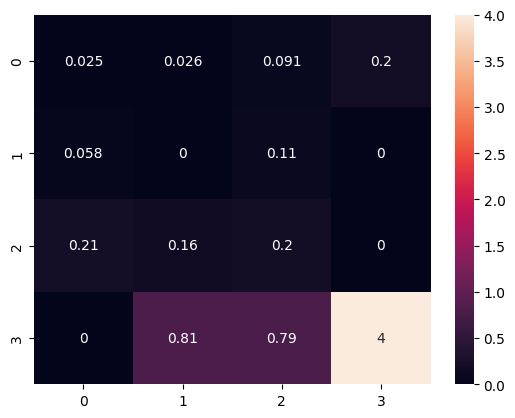

In [21]:
seaborn.heatmap(v.reshape((n, n)), annot=True)

## (4) Equiprobable function to get random action

In [38]:
def equiprobable():
    return np.random.randint(0, len(actions))

### FrozenLake sandbox

In [27]:
import gymnasium as gym
from time import time

In [28]:
env = gym.make("FrozenLake-v1", 
                #    map_name="8x8", 
               is_slippery=False, 
               desc=["SFFF", 
                     "FHFH", 
                     "FFFH", 
                     "HFFG"],
                render_mode="human"
                )

env.reset()
env.render()

## (5) Get_episode()

In [ ]:
"""
Створити  функцію  get_episode,  яка  приймає  у  якості  аргументу 
екземпляр середовища, а результатом функції є епізод, тобто список 
кортежів,  кожен  з  яких  зберігає  всі  характеристики  кожного  кроку 
агента  (тобто  попередній  стан,  дію,  винагороду,  поточний  стан, 
значення параметрів terminated та truncated).  
Вибір  агентом  дії  у  кожному  стані  на  даному  етапі  реалізуйте  на 
основі  функції  equiprobable,  або,  іншими  словами,  на  основі 
рівноймовірної (випадкової) стратегії 𝜋1."""

In [44]:
def get_episode(env):
    curr_state, _ = env.reset()

    terminated, truncated = False, False
    episode = []
    while not (terminated or truncated):
        action = equiprobable()
        next_state, reward, terminated, truncated, _ = env.step(action)
        episode.append((curr_state, action, reward, next_state, terminated, truncated))
        curr_state = next_state
    
    return episode


In [45]:
episode = get_episode(env)
episode


[(0, 0, 0.0, 0, False, False),
 (0, 1, 0.0, 4, False, False),
 (4, 2, 0.0, 5, True, False)]

## (6) Graphs of episode

In [ ]:
"""Виконати 100 епізодів за допомогою функції get_episode. Виведіть 
на екран два графіки: винагорода та тривалість епізоду."""

In [50]:
import time


In [51]:
exec_time_arr = []
rewards = []
for _ in range(100):
    s_time = time.perf_counter()
    episode = get_episode(env)
    total_time = time.perf_counter() - s_time
    
    rewards.append(sum([step[2] for step in episode]))
    exec_time_arr.append(total_time)


In [52]:
import matplotlib.pyplot as plt

[]

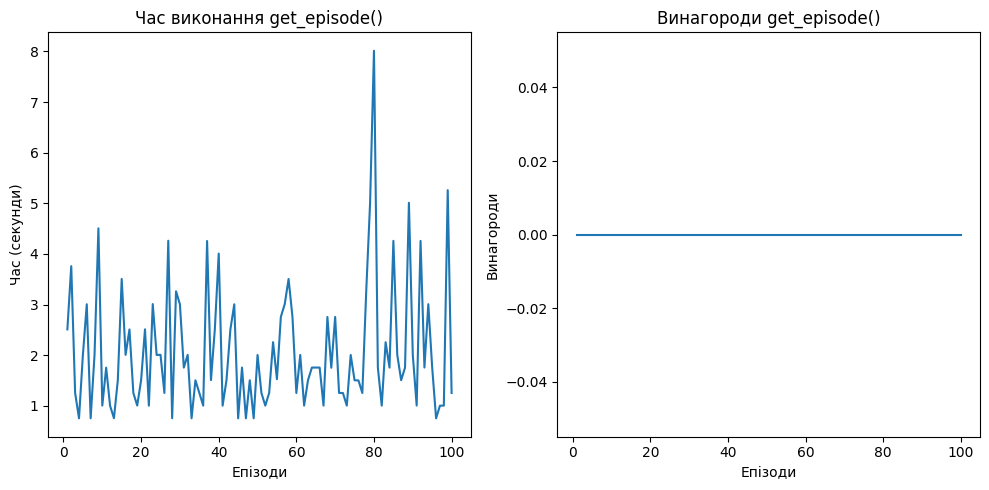

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(range(1, 101), exec_time_arr)
ax1.set_title("Час виконання get_episode()") # враховуючи час очікування потоку
ax1.set_xlabel("Епізоди")
ax1.set_ylabel("Час (секунди)")

ax2.plot(range(1, 101), rewards)
ax2.set_title("Винагороди get_episode()")
ax2.set_xlabel("Епізоди")
ax2.set_ylabel("Винагороди")

plt.tight_layout()
plt.plot()


## (7) Iteration policy method with optimal strategy search

In [ ]:
""" Реалізувати  метод  Ітерації  ціни  (Value  Iteration)  для  знаходження 
оптимальної стратегії за заданою початковою"""

In [62]:
env_space = ["SFFF", 
             "FHFH", 
             "FFFH", 
             "HFFG"]


In [64]:
env_space = np.array([[s for s in line] for line in env_space])
env_space


In [69]:
# Construct all possible combinations
states_ids = np.arange(16).reshape((4, 4))
states_ids

In [93]:
s0 = (1, 0)
s_t = (3, 3)

In [106]:
chain = set(s0)

In [ ]:
if chain[0] != s_t:
    if s0[0] > 0:
        chain.append(s0[0] - 1, s0[1])
    